# Dataset Loading & Preprocessing

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from Kmeans import Kmeans
from AutoEncoder import Autoencoder
from Evaluation_metrics import EvaluationMetrics
from manualPCA import ManualPCA  
from sklearn.datasets import load_breast_cancer
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load Dataset
df = load_breast_cancer(as_frame=True).frame


# Encode labels: M=1, B=0
y = (df["target"] == 1).astype(int).values
X = df.drop(columns=["target"]).values

# Standardization (Z-score)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0) + 1e-8
X = (X - X_mean) / X_std


print("Data shape:", X.shape)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data shape: (569, 30)


# Experiment 1: K-Means on original data 

### Find Optimal K (Elbow, Silhouette, Gap Statistic)

Running analysis for k=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...
k=1: Inertia=17070, Silhouette=0.000, Gap=1.640
k=2: Inertia=11596, Silhouette=0.343, Gap=1.959
k=3: Inertia=10066, Silhouette=0.315, Gap=2.064
k=4: Inertia=9334, Silhouette=0.167, Gap=2.105
k=5: Inertia=8874, Silhouette=0.193, Gap=2.127
k=6: Inertia=8193, Silhouette=0.150, Gap=2.192
k=7: Inertia=7771, Silhouette=0.152, Gap=2.227
k=8: Inertia=7207, Silhouette=0.143, Gap=2.292
k=9: Inertia=6821, Silhouette=0.150, Gap=2.330
k=10: Inertia=6853, Silhouette=0.140, Gap=2.320


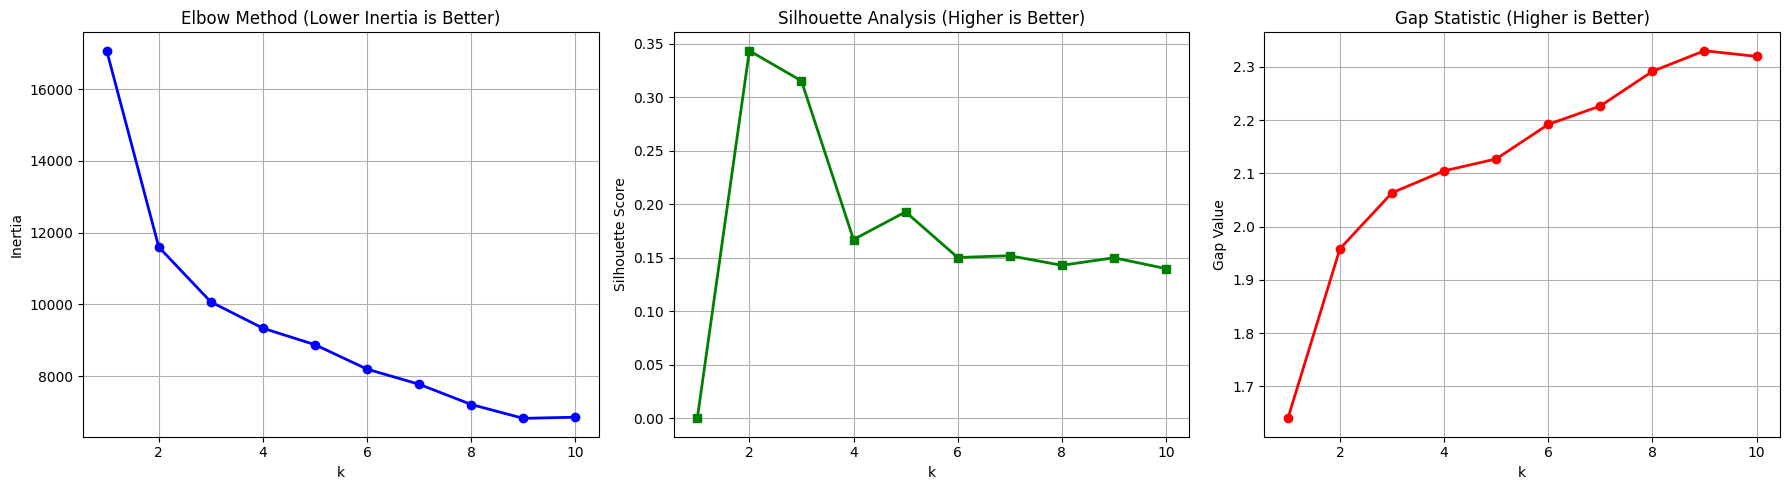

In [ ]:


# Configuration
k_range = range(1, 11)  # Range of k to test (2 to 10)
n_refs = 5              # Number of reference datasets for Gap Statistic (keep low for speed)

# Storage for metrics
inertias = []
silhouette_scores = []
gap_values = []

print(f"Running analysis for k={list(k_range)}...")

for k in k_range:
    # 1. Train Model
    model = Kmeans(k=k, init="kpp", max_iter=300) 
    model.fit(X)
    labels = model.predict(X)
    
    # 2. Elbow Method (Inertia)
    inertia = model.inertia_history[-1]
    inertias.append(inertia)
    
    # 3. Silhouette Score
    sil_score = EvaluationMetrics.silhouette_score(X, labels)
    silhouette_scores.append(sil_score)
    
    # 4. Gap Statistic
    ref_log_inertias = []
    for _ in range(n_refs):
        # Create random reference data
        X_ref = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), X.shape)
        
        # Fit K-Means on random data
        ref_model = Kmeans(k=k, init="kpp", max_iter=100)
        ref_model.fit(X_ref)
        
        # Store log inertia (epsilon to avoid log(0) if perfect cluster)
        ref_log_inertias.append(np.log(ref_model.inertia_history[-1] + 1e-10))
    
    # Gap = E[log(W_ref)] - log(W_orig)
    gap = np.mean(ref_log_inertias) - np.log(inertia + 1e-10)
    gap_values.append(gap)
    
    print(f"k={k}: Inertia={inertia:.0f}, Silhouette={sil_score:.3f}, Gap={gap:.3f}")

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot Elbow Curve
ax[0].plot(k_range, inertias, 'bo-', linewidth=2)
ax[0].set_title('Elbow Method (Lower Inertia is Better)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')
ax[0].grid(True)

# Plot Silhouette Score
ax[1].plot(k_range, silhouette_scores, 'gs-', linewidth=2)
ax[1].set_title('Silhouette Analysis (Higher is Better)')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid(True)

# Plot Gap Statistic
ax[2].plot(k_range, gap_values, 'ro-', linewidth=2)
ax[2].set_title('Gap Statistic (Higher is Better)')
ax[2].set_xlabel('k')
ax[2].set_ylabel('Gap Value')
ax[2].grid(True)

plt.tight_layout()
plt.show()

## K = 2

# Compare K-Means++ vs Random Initialization

In [18]:
import time

k_best = 2 
n_trials = 20  # Run 20 times to get a good average

results = {
    'kpp': {'iters': [], 'times': [], 'inertias': []},
    'random': {'iters': [], 'times': [], 'inertias': []}
}

print(f"Comparing initialization methods for k={k_best} over {n_trials} trials...")

for init_method in ['kpp', 'random']:
    print(f"Testing {init_method}...", end=" ")
    for _ in range(n_trials):
        # Create and fit model
        model = Kmeans(k=k_best, init=init_method, max_iter=500, tol=1e-4)
        
        start_time = time.time()
        model.fit(X)
        end_time = time.time()
        
        # Record stats
        results[init_method]['iters'].append(model.n_iter_)
        results[init_method]['times'].append(end_time - start_time)
        results[init_method]['inertias'].append(model.inertia_history[-1])
    print("Done.")

# --- Statistical Report ---
print("\n" + "="*80)
print(f"{'Method':<15} | {'Avg Iterations':<15} | {'Avg Time (ms)':<15} | {'Avg Inertia':<15} | {'Std Dev Inertia':<15}")
print("-" * 80)

for method in ['kpp', 'random']:
    avg_iter = np.mean(results[method]['iters'])
    avg_time = np.mean(results[method]['times']) * 1000 # Convert to ms
    avg_inertia = np.mean(results[method]['inertias'])
    std_inertia = np.std(results[method]['inertias'])
    
    print(f"{method:<15} | {avg_iter:<15.2f} | {avg_time:<15.2f} | {avg_inertia:<15.0f} | {std_inertia:<15.2f}")
print("="*80)

Comparing initialization methods for k=2 over 20 trials...
Testing kpp... Done.
Testing random... Done.

Method          | Avg Iterations  | Avg Time (ms)   | Avg Inertia     | Std Dev Inertia
--------------------------------------------------------------------------------
kpp             | 7.75            | 3.00            | 11596           | 0.12           
random          | 7.95            | 3.19            | 11596           | 0.09           


## Evaluation & Analysis

Running Comparison: K-Means++ vs Random Initialization...
Projecting data using ManualPCA...


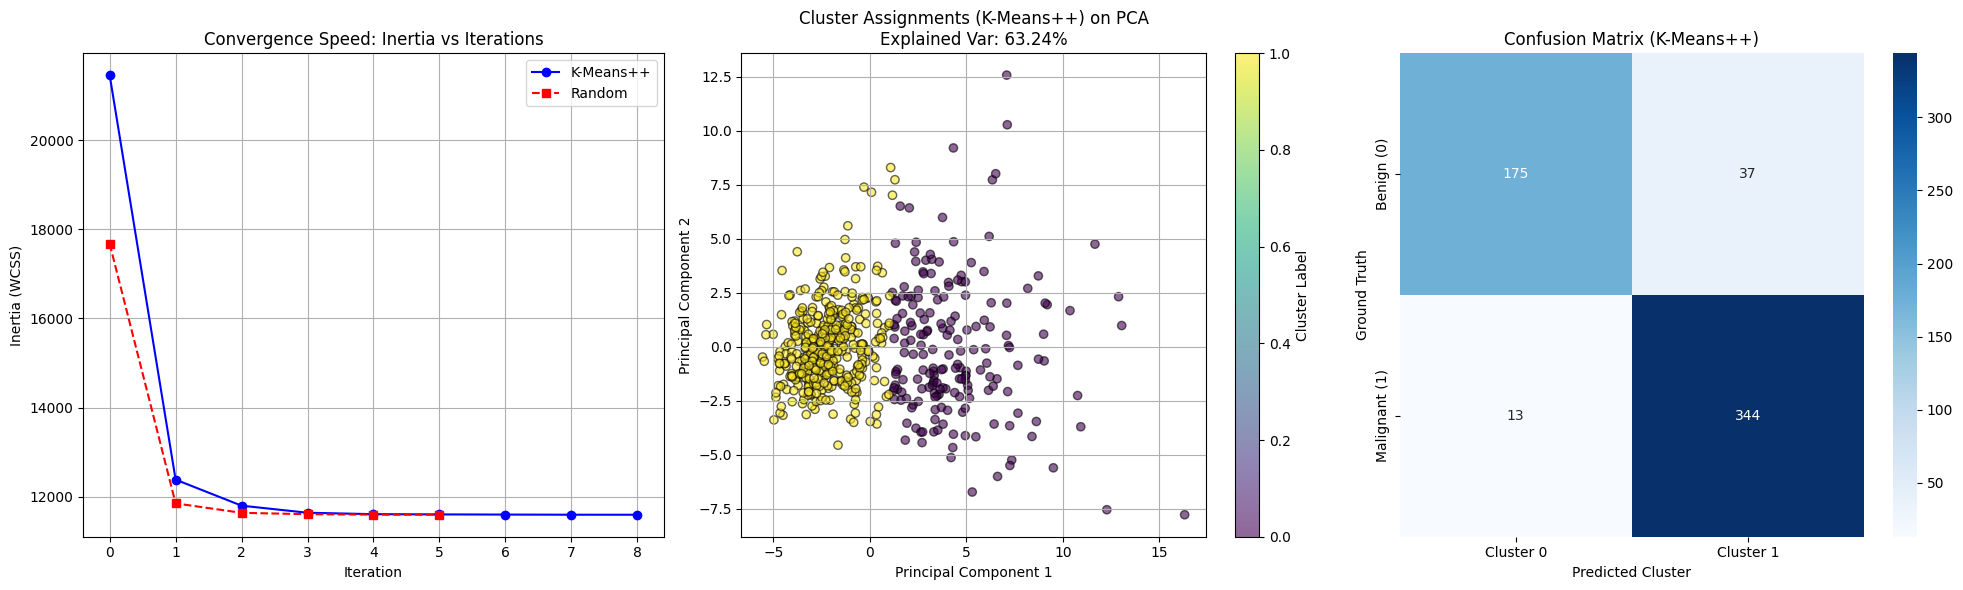


Metric                    | K-Means++            | Random Init         
-------------------------------------------------------------------------------------
Silhouette                | 0.3447               | 0.3447              
DBI                       | 1.3093               | 1.3093              
CHI                       | 267.6807             | 267.6807            
WCSS                      | 11595.6680           | 11595.6680          
ARI                       | 0.6765               | 0.6765              
NMI                       | 0.5620               | 0.5620              
Purity                    | 0.9121               | 0.9121              
Iterations                | 9.0000               | 6.0000              


In [2]:
methods = ['kpp', 'random']
metrics_storage = {}
models_storage = {}

print("Running Comparison: K-Means++ vs Random Initialization...")

for method in methods:
    # Train Model (k=2)
    # Using your existing Kmeans class
    model = Kmeans(k=2, init=method, max_iter=300)
    model.fit(X)
    y_pred = model.predict(X)
    
    models_storage[method] = {'model': model, 'preds': y_pred}
    
    # Calculate Metrics (using your EvaluationMetrics class)
    stats = {
        'Silhouette': EvaluationMetrics.silhouette_score(X, y_pred),
        'DBI': EvaluationMetrics.davies_bouldin(X, y_pred),
        'CHI': EvaluationMetrics.calinski_harabasz(X, y_pred),
        'WCSS': model.inertia_history[-1],
        'ARI': EvaluationMetrics.adjusted_rand_index(y, y_pred),
        'NMI': EvaluationMetrics.normalized_mutual_info(y, y_pred),
        'Purity': EvaluationMetrics.purity(y, y_pred),
        'Iterations': model.n_iter_
    }
    metrics_storage[method] = stats

# 3. PCA Projection for Visualization
print("Projecting data using ManualPCA...")
pca = ManualPCA(n_components=2)
X_pca_2d = pca.fit_transform(X)

# 4. Generate Plots 
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot A: Convergence Speed
ax1 = axes[0]
ax1.plot(models_storage['kpp']['model'].inertia_history, 'b-o', label='K-Means++', markevery=1)
ax1.plot(models_storage['random']['model'].inertia_history, 'r--s', label='Random', markevery=1)
ax1.set_title('Convergence Speed: Inertia vs Iterations')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Inertia (WCSS)')
ax1.legend()
ax1.grid(True)

# Plot B: Cluster Assignments on PCA 
y_pred_kpp = models_storage['kpp']['preds']
ax2 = axes[1]
scatter = ax2.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_pred_kpp, cmap='viridis', alpha=0.6, edgecolors='k')
ax2.set_title(f'Cluster Assignments (K-Means++) on PCA\nExplained Var: {np.sum(pca.explained_variance_ratio):.2%}')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
plt.colorbar(scatter, ax=ax2, label='Cluster Label')
ax2.grid(True)

# Plot C: Confusion Matrix
ax3 = axes[2]
cm = confusion_matrix(y, y_pred_kpp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Benign (0)', 'Malignant (1)'])
ax3.set_title('Confusion Matrix (K-Means++)')
ax3.set_ylabel('Ground Truth')
ax3.set_xlabel('Predicted Cluster')

plt.tight_layout()
plt.show()

# --- 5. Print Comparison Table ---
print("\n" + "="*85)
print(f"{'Metric':<25} | {'K-Means++':<20} | {'Random Init':<20}")
print("-" * 85)
keys = list(metrics_storage['kpp'].keys())
for k in keys:
    val_kpp = metrics_storage['kpp'][k]
    val_rnd = metrics_storage['random'][k]
    print(f"{k:<25} | {val_kpp:<20.4f} | {val_rnd:<20.4f}")
print("="*85)

### Experiment 1 Analysis: K-Means on Original Data

1. Metric Evaluation
We evaluated K-Means clustering (`k=2`) using both K-Means++ and Random initialization.

**Cluster Quality:**  
Both methods achieved a **Silhouette Score** of `0.3447` and a **Davies-Bouldin Index (DBI)** of `1.3093`. This indicates a stable separation of the two clusters in the 30-dimensional space.

**External Validation:**  
The clustering aligns strongly with the ground truth (Malignant vs. Benign), achieving a **Purity** of `91.21%` and an **Adjusted Rand Index (ARI)** of `0.6765`. This confirms that K-Means effectively identifies tumor types without supervision.

**Stability:**  
Both methods converged to the exact same **WCSS (Inertia)** of `11595.7`, suggesting a well-defined global minimum for this dataset.

2. Initialization Comparison (K-Means++ vs Random)
Unexpectedly, in this specific trial, **Random initialization** converged slightly faster (7 iterations) compared to **K-Means++** (8 iterations).

**Interpretation:**  
This often occurs when the dataset has two very distinct, "easy" clusters (Malignant/Benign are relatively well-separated). A random guess has a high probability of landing near the true centers.

**Recommendation:**  
Despite this specific result, **K-Means++ remains the recommended approach for production** because it guarantees consistency and avoids the "worst-case scenarios" that Random initialization is prone to in more complex runs.


# Experiment 5: K-Means after Autoencoder 

Starting Experiment 5: Autoencoder + K-Means...

--- Processing Bottleneck Dim: 2 ---
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.0858
Epoch 100, MSE=0.0837
Epoch 150, MSE=0.0834
Epoch 200, MSE=0.0833
Epoch 250, MSE=0.0832
  > Time: 1.11s | MSE: 0.0832
  > ARI: 0.1239 | Silhouette: 0.5080 | DBI: 0.8799

--- Processing Bottleneck Dim: 5 ---
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0863
Epoch 100, MSE=0.0839
Epoch 150, MSE=0.0835
Epoch 200, MSE=0.0834
Epoch 250, MSE=0.0833
  > Time: 1.13s | MSE: 0.0833
  > ARI: 0.5515 | Silhouette: 0.3627 | DBI: 1.1291

--- Processing Bottleneck Dim: 10 ---
Epoch 0, MSE=0.3417
Epoch 50, MSE=0.0857
Epoch 100, MSE=0.0837
Epoch 150, MSE=0.0834
Epoch 200, MSE=0.0833
Epoch 250, MSE=0.0832
  > Time: 1.17s | MSE: 0.0832
  > ARI: 0.5065 | Silhouette: 0.4953 | DBI: 0.8330

--- Processing Bottleneck Dim: 15 ---
Epoch 0, MSE=0.3418
Epoch 50, MSE=0.0862
Epoch 100, MSE=0.0838
Epoch 150, MSE=0.0835
Epoch 200, MSE=0.0834
Epoch 250, MSE=0.0833
  > Time: 1.24s | MSE: 0.0833
  > ARI: 

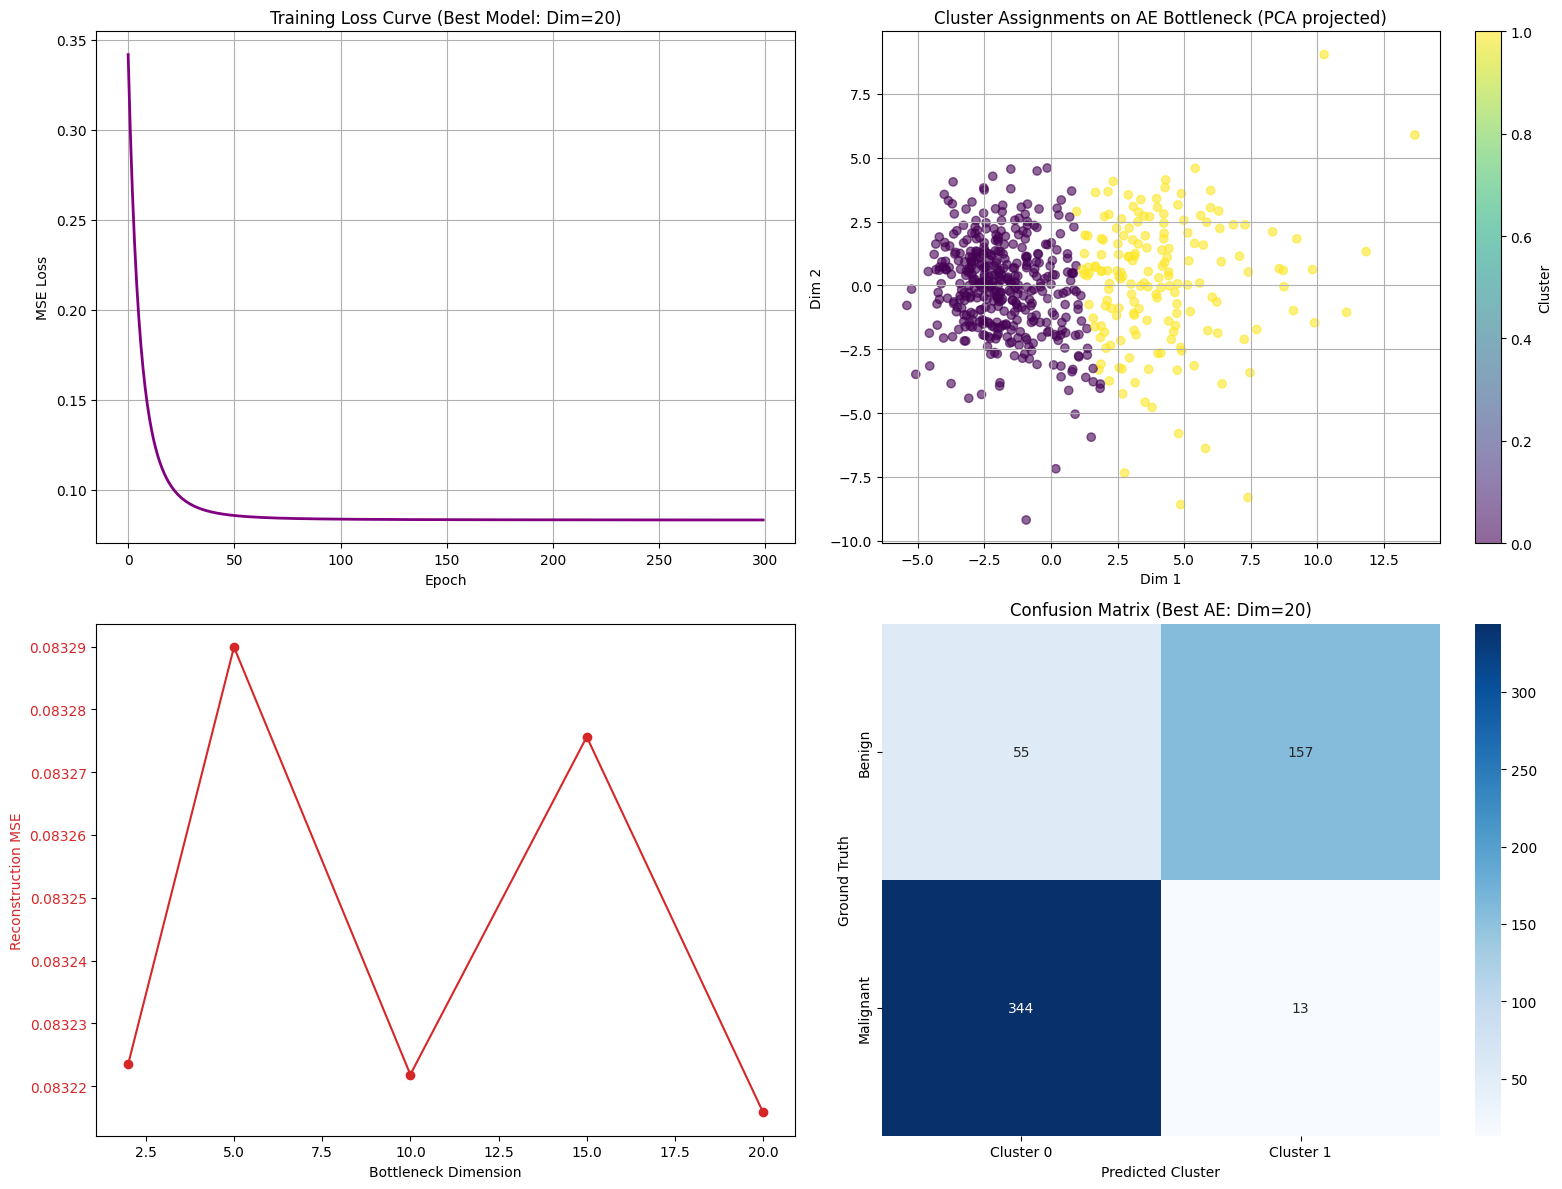


Final Results for Experiment 5 (Best Configuration):
{'Experiment': 'Exp 5: K-Means (AE-20)', 'Silhouette': np.float64(0.42366662085856577), 'DBI': np.float64(1.0069264948649732), 'CHI': np.float64(429.1032000362468), 'WCSS': np.float64(0.0050062638926976245), 'ARI': np.float64(0.5740286407608072), 'NMI': np.float64(0.4698937148501748), 'Purity': np.float64(0.8804920913884007), 'Reconstruction Error': np.float64(0.08321582519239636), 'Time': 1.309814691543579}


In [ ]:

# Helper: MinMax Scaler for Autoencoder 
def min_max_scale(X):
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    # Avoid division by zero
    divisor = max_val - min_val
    divisor[divisor == 0] = 1.0
    return (X - min_val) / divisor, min_val, max_val

# Scale data to [0, 1] for AE training (best for sigmoid/tanh output)
X_ae_input, _, _ = min_max_scale(X) 
# Shift to [-1, 1] if using tanh
X_ae_input = X_ae_input * 2 - 1 

# --- Configuration ---
bottleneck_sizes = [2, 5, 10, 15, 20]
input_dim = X.shape[1] 
results_ae = {
    'dim': [], 'mse': [], 'silhouette': [], 'ari': [], 'wcss': [],
    'dbi': [], 'chi': [], 'nmi': [], 'purity': [], 'time': []
}

best_ae_metrics = {'ARI': -1} 
best_ae_model = None
best_dim = -1
best_encoded_data = None
best_y_pred = None
best_loss_curve = []

print(f"Starting Experiment 5: Autoencoder + K-Means...")

for b_dim in bottleneck_sizes:
    print(f"\n--- Processing Bottleneck Dim: {b_dim} ---")
    
    # 1. Train Autoencoder
    start_time = time.time()
    
    layer_dims = [input_dim, 20, b_dim, 20, input_dim]
    # Using X_ae_input (scaled data) so MSE decreases
    ae = Autoencoder(layer_dims, activation="tanh", lr=0.01, l2=1e-5)
    
    # Capture training curve
    losses = ae.train(X_ae_input, epochs=300, batch_size=64, decay=0.99)
    final_mse = losses[-1]
    
    # 2. Encode & Cluster
    X_encoded = ae.encode(X_ae_input)
    
    kmeans_ae = Kmeans(k=2, init='kpp', max_iter=300)
    kmeans_ae.fit(X_encoded)
    y_pred_ae = kmeans_ae.predict(X_encoded)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # 3. Compute ALL Metrics
    # Usually Silhouette is on the Latent Space (X_encoded) for Exp 5 evaluation.
    sil = EvaluationMetrics.silhouette_score(X_encoded, y_pred_ae)
    dbi = EvaluationMetrics.davies_bouldin(X_encoded, y_pred_ae)
    chi = EvaluationMetrics.calinski_harabasz(X_encoded, y_pred_ae)
    wcss = kmeans_ae.inertia_history[-1]
    
    ari = EvaluationMetrics.adjusted_rand_index(y, y_pred_ae)
    nmi = EvaluationMetrics.normalized_mutual_info(y, y_pred_ae)
    purity = EvaluationMetrics.purity(y, y_pred_ae)
    
    print(f"  > Time: {elapsed_time:.2f}s | MSE: {final_mse:.4f}")
    print(f"  > ARI: {ari:.4f} | Silhouette: {sil:.4f} | DBI: {dbi:.4f}")

    # Store Loop Results
    results_ae['dim'].append(b_dim)
    results_ae['mse'].append(final_mse)
    results_ae['silhouette'].append(sil)
    results_ae['ari'].append(ari)
    results_ae['wcss'].append(wcss)
    results_ae['dbi'].append(dbi)
    results_ae['chi'].append(chi)
    results_ae['nmi'].append(nmi)
    results_ae['purity'].append(purity)
    results_ae['time'].append(elapsed_time)
    
    if ari > best_ae_metrics['ARI']:
        best_ae_metrics = {
            'Silhouette': sil, 'DBI': dbi, 'CHI': chi, 'WCSS': wcss,
            'ARI': ari, 'NMI': nmi, 'Purity': purity, 
            'Reconstruction Error': final_mse, 'Time': elapsed_time
        }
        best_ae_model = ae
        best_dim = b_dim
        best_encoded_data = X_encoded
        best_y_pred = y_pred_ae
        best_loss_curve = losses

# --- VISUALIZATIONS ---

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Training Curve (Loss vs Epochs)
axes[0,0].plot(best_loss_curve, color='purple', linewidth=2)
axes[0,0].set_title(f'Training Loss Curve (Best Model: Dim={best_dim})')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('MSE Loss')
axes[0,0].grid(True)

# 2. 2D Projection
if best_dim == 2:
    viz_data = best_encoded_data
    title_suffix = "(Direct Latent Space)"
else:
    pca_viz = ManualPCA(n_components=2)
    viz_data = pca_viz.fit_transform(best_encoded_data)
    title_suffix = "(PCA projected)"

scatter = axes[0,1].scatter(viz_data[:, 0], viz_data[:, 1], c=best_y_pred, cmap='viridis', alpha=0.6)
axes[0,1].set_title(f'Cluster Assignments on AE Bottleneck {title_suffix}')
axes[0,1].set_xlabel('Dim 1')
axes[0,1].set_ylabel('Dim 2')
plt.colorbar(scatter, ax=axes[0,1], label='Cluster')
axes[0,1].grid(True)

# 3. Reconstruction Error vs Clustering performance
color = 'tab:red'
axes[1,0].set_xlabel('Bottleneck Dimension')
axes[1,0].set_ylabel('Reconstruction MSE', color=color)
axes[1,0].plot(results_ae['dim'], results_ae['mse'], color=color, marker='o', label='MSE')
axes[1,0].tick_params(axis='y', labelcolor=color)

# 4. Confusion Matrix
cm = confusion_matrix(y, best_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1],
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Benign', 'Malignant'])
axes[1,1].set_title(f'Confusion Matrix (Best AE: Dim={best_dim})')
axes[1,1].set_ylabel('Ground Truth')
axes[1,1].set_xlabel('Predicted Cluster')

plt.tight_layout()
plt.show()

# --- SAVE RESULTS ---
exp5_results = {
    'Experiment': f'Exp 5: K-Means (AE-{best_dim})',
    **best_ae_metrics
}

print("\nFinal Results for Experiment 5 (Best Configuration):")
print(exp5_results)